DATA LOADING AND PREPARATION

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# SFOAE data loading
mat_SFOAE = scipy.io.loadmat('data/SFOAE/sfoae20dBg130TM45R19rs2.mat')

freq_SFOAE = mat_SFOAE['Fvect'].flatten()  # frequency axis
SFOAE = mat_SFOAE['oaeNum20'].flatten()  # SFOAE wave
CRcomp = mat_SFOAE['CRc20'].flatten()  # CR component
NLcomp = mat_SFOAE['Yunl20'].flatten()  # NL component

# unwrapped phase of the SFOAE wave
phase_unwrap_SFOAE = np.unwrap(np.angle(SFOAE))


CEPSTRUM ANALYSIS ALGORITHM

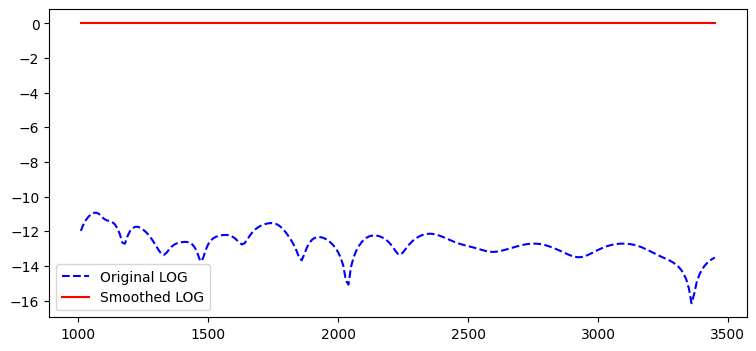

In [11]:
from scipy.signal import savgol_filter
from cutoff_window import *

# smoothing the phase with a Savitzky-Golay filter
smoothed_phase = savgol_filter(phase_unwrap_SFOAE, 5, 1)
# smoothing is necessary here to render the transformation monotonic
# the minus sign then guarantees that phi increases with f
phi = -smoothed_phase/(2*np.pi)
# calculate phi (normalized phase) with respect to frequency
freq_phi = np.fft.fftfreq(len(phi))

# calculate logarithm of SFOAE and perform FFT with respect to phi
log_SFOAE = np.log(SFOAE)  # = np.log(np.abs(SFOAE)) + 1j*phase_unwrap_SFOAE
log_SFOAE_reshaped = log_SFOAE.reshape((1, -1))

# swap axes and perform FFT with respect to phi
log_SFOAE_phi = np.swapaxes(log_SFOAE_reshaped, 0, 1)
fft_log_SFOAE_phi = np.fft.fft(log_SFOAE_reshaped + 2*np.pi*1j*phi, axis=1)
fft_log_SFOAE_phi = np.squeeze(fft_log_SFOAE_phi)

quefrency = np.fft.fftfreq(len(fft_log_SFOAE_phi))

N_cycles = np.round(np.max(phi) - np.min(phi)) # phi is already in cycles (no need to divide by 2pi)
eta_c = 0.9*N_cycles # quefrency cutoff
smooth_order = 3  # order of the smoothing function
window = 0 #rectWindow(quefrency, eta_c) # TODO
a = np.multiply(window, fft_log_SFOAE_phi)

log_0_SFOAE = np.fft.ifft(np.multiply(window, fft_log_SFOAE_phi), axis=0) - 2*np.pi*1j*phi

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, log_SFOAE, "b--", label="Original LOG")
ax.plot(freq_SFOAE, log_0_SFOAE, "r", label="Smoothed LOG")
plt.legend()
plt.show()


RESULTS DISPLAYING

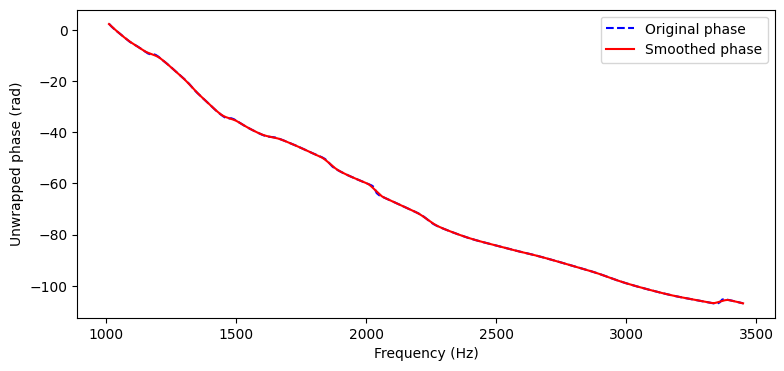

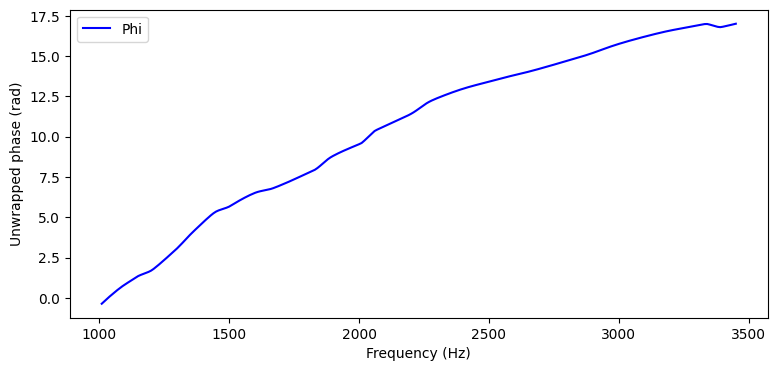

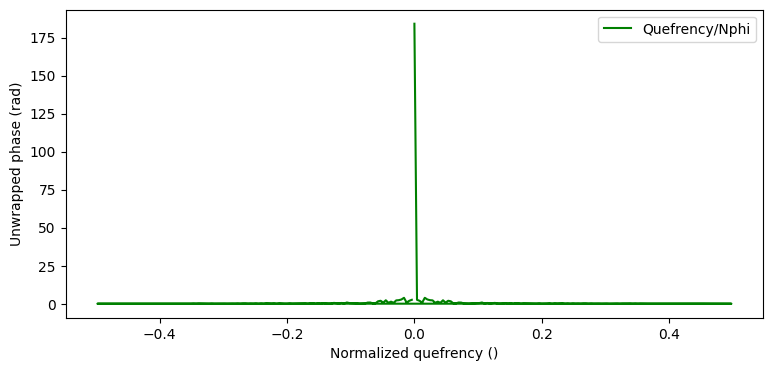

In [12]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, phase_unwrap_SFOAE, "b--", label="Original phase")
ax.plot(freq_SFOAE, smoothed_phase, "r", label="Smoothed phase")
# ax.set_xscale('log')
# ax.set_xlim([1000, 3.5e3])
# ax.set_ylim([0, 20])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Unwrapped phase (rad)')
ax.legend()
# ax.set_title('Group delay 20 dB')
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, phi, "b", label="Phi")
# ax.set_xscale('log')
# ax.set_xlim([1000, 3.5e3])
# ax.set_ylim([0, 20])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Unwrapped phase (rad)')
ax.legend()
# ax.set_title('Group delay 20 dB')
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_phi, np.abs(np.fft.fft(np.real(np.log(SFOAE)))) /
        N_cycles, "g", label="Quefrency/Nphi")
# ax.set_xscale('log')
# ax.set_xlim([1000, 3.5e3])
# ax.set_ylim([0, 20])
ax.set_xlabel('Normalized quefrency ()')
ax.set_ylabel('Unwrapped phase (rad)')
ax.legend()
# ax.set_title('Group delay 20 dB')
plt.show()


EXPERIMENT

In [13]:
import numpy as np


def recursive_exponential_filter(x, tc):
    """
    Apply recursive-exponential filter Sn to input signal x with cutoff tc.
    """
    n = len(x)
    y = np.zeros_like(x)
    Ft = np.zeros(n)
    Ft[0] = 1.0
    for i in range(1, n):
        Ft[i] = np.exp(-1.0 / tc) * Ft[i-1]
    for i in range(n):
        if i == 0:
            y[i] = x[i]
        else:
            y[i] = (1 - Ft[i]) * x[i] + Ft[i] * y[i-1]
    return y